<div style="text-align: right">**November 28th**</div>
***
# <center>Pre-Game Regression</center>

Today's meeting will focus on building and improving upon a model for pre-game outcome prediction, meaning a model that only uses features that are known before the game begins as predictors. Things like champion selections, team quality, opponent quality, and intended playstyles.

To build this model I will:

- Establish a baseline regression for both a complete feature DF and a pre-game feature DF.
- Update the pre-game feature DF by:
    - <span style="color:blue">Creating new categorical champion selections through k-means clustering.</span>
    - <span style="color:blue">Expanding/updating existing categoricals such as team/opponent quality.</span>
    - <span style="color:blue">(If time permits) Run a second k-means cluster on the clustering derived champion categoricals grouped by team and gameid to identify styles of team composition.</span>


- (If time permits) Evaluate all of the derived clusters and implement more interprettable labels for each.
- Run a new pre-game regression to test the usefulness of the derived features.

#### Import modules and dataframes
***

In [80]:
%store -r teamDF
%store -r norm_teamDF
%store -r playerDF
%store -r new_featuresDF


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

#### Establish baselines (full-feature DF):
***

Again, I'll set the regressors and split the data into train and test.

In [191]:
vif_reducers = ['result','elementals', 'k', 'd', 'ckpm', 'fbvictim',
                                               'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills',
                                               'totalgold','gamelength', 'dmgtochamps', 'teamkills', 'teamdeaths',
                                                      'wardkills', 'monsterkills','goldspent', 'league', 'split',
                                                      'week', 'game', 'patchno', 'playerid', 'position', 'player', 'champion']
regressors = list(set(list(norm_teamDF)) - set(vif_reducers))
X = norm_teamDF.loc[:, regressors]
y = norm_teamDF.loc[:,'result']

#### Establish baselines (full-feature DF):
***

Then, I'll rebuild the model and pass it to sklearn's cross_val_score to view an array of accuracies across each of the logistic regressions.

In [46]:
lr = LogisticRegression()    
scores = cross_val_score(lr, X, y, cv=10)

print("The CV accuracies were:", scores)
print("\nWith a mean accuracy of {}, a minimum of {}, and a maximum of {}".format(scores.mean(), min(scores), max(scores)))

The CV accuracies were: [ 0.9832246   0.99068034  0.98695247  0.97947761  0.98600746  0.97574627
  0.98225957  0.97665733  0.97945845  0.99159664]

With a mean accuracy of 0.9832060741212372, a minimum of 0.9757462686567164, and a maximum of 0.9915966386554622


#### Establish baselines (full-feature DF):
***

As before, this is an extremely accurate model for predicting the winner of games. But, also as before, this is not entirely usefull because it relies on information that reflects how the team is already doing in the game. Since the ultimate goal of this study is to unearth information that informs strategic decision making for an organization, this last model would be the equivalent of telling a basketball team that the ideal strategy to win is scoring more points than your opponent.

With that in mind, I'll construct the same model using only information available at the start of the game.

#### Establish baselines (pre-game DF):
***

First I'll determine which features represent in-game data and remove them.

In [23]:
not_dummies = [c for c in list(X) if not any(d in c for d in ['ban', 'Jungle_', 'Middle_', 'Support_', 'Top_', 'ADC_'])]
print(not_dummies)

['fbtime', 'teambaronkills', 'opp_quality_Fair', 'pace_Walk', 'elders', 'xpat10', 'opp_quality_Good', 'opp_quality_Poor', 'herald', 'goldat15', 'quality_Good', 'earthdrakes', 'fb', 'opptowerkills', 'gspd', 'winRate', 'pace_Amble', 'heraldtime', 'aggression_Wild', 'quality_Great', 'quality_Poor', 'oppxpat10', 'aggression_Moderate', 'aggression_Frisky', 'wpm', 'oppgoldat15', 'pace_Sprint', 'goldat10', 'fbaron', 'wardshare', 'totalGames', 'ft', 'a', 'oppelementals', 'fd', 'invisiblewardclearrate', 'wcpm', 'fbarontime', 'aggression_Alert', 'airdrakes', 'dmgtochampsperminute', 'visionwards', 'firsttothreetowers', 'side_Red', 'fttime', 'firedrakes', 'quality_Fair', 'kpm', 'oppelders', 'monsterkillsownjungle', 'waterdrakes', 'monsterkillsenemyjungle', 'oppbaronkills', 'okpm', 'visionwardbuys', 'oppdragkills', 'fdtime', 'date', 'firstmidouter', 'opp_quality_Great', 'earnedgpm', 'pace_Trot', 'cspm', 'teamdragkills', 'fbassist', 'oppgoldat10', 'visiblewardclearrate', 'teamtowerkills']


Unfortunately, no way to do this besides manually.

In [190]:
in_game_feats = ['fbtime', 'teambaronkills', 'elders', 'xpat10', 'herald', 'goldat15',
                                           'earthdrakes', 'fb', 'opptowerkills', 'gspd', 'heraldtime', 'oppxpat10',
                                           'oppgoldat15', 'goldat10', 'fbaron','wardshare', 'ft', 'a', 'oppelementals',
                                           'fd', 'fbarontimme', 'airdrakes','dmgtochampsperminute', 'firsttothreetowers',
                                           'fttime', 'firedrakes', 'kpm', 'oppelders', 'monsterkillsownjungle',
                                           'waterdrakes', 'monsterkillsenemyjungle','oppbaronkills', 'okpm', 'oppdragkills',
                                           'fdtime', 'date', 'firstmidouter','earnedgpm', 'cspm', 'teamdragkills',
                                           'fbassist','oppgoldat10', 'teamtowerkills']
pg_regressors = list(set(regressors) - set(in_game_feats))

print('Kept features:', [c for c in pg_regressors if not any(d in c for d in ['ban', 'Jungle_', 'Middle_', 'Support_', 'Top_', 'ADC_'])])

Kept features: ['opp_quality_Fair', 'pace_Walk', 'opp_quality_Good', 'opp_quality_Poor', 'quality_Good', 'winRate', 'pace_Amble', 'aggression_Wild', 'quality_Great', 'quality_Poor', 'aggression_Moderate', 'aggression_Frisky', 'wpm', 'pace_Sprint', 'totalGames', 'invisiblewardclearrate', 'wcpm', 'fbarontime', 'aggression_Alert', 'visionwards', 'side_Red', 'quality_Fair', 'visionwardbuys', 'opp_quality_Great', 'pace_Trot', 'visiblewardclearrate']


I'd like to keep ward type features (wpm, invisblewardclearrate, visiblewardclearrate, visionwards, visionwardbuys, and wcpm) as vision control can be a strategic decision, but these features are also influenced by how the game is going. The winning team has more map control and thus can place more wards or have the freedom to clear more. Depending on how strong their coefficients are, I may change.

Other features that were dropped but can also reflect strategic choices:
- jungle control (monsterkillsownjungle, monsterkillsenemyjungle)
- neutral objective control (baron, dragon, and harold related features)
- early game priority (first blood, first turret features, and gold/xp at 10 minutes)

I felt these features were more influenced by how the game was already unfolding, but I believe they can also be strategic priorities. I will possible do another analysis with these features included but only evaluated observations that are close games as determined by gspd. Hopefully, the clustering of team compositions will naturally absorb some of this information to reflect a team's predetermined objective and vision control priorities (for instance, teams with tanky supports for vision, high single target damage for objective control, high mobility jungle and solo-laners for jungle control, pick compositions for early game, etc).

**ERROR NOTE: Categoricals from original dataframe encoded as 0 or 1 and stored as a numeric datatype were unintentionally normalized (such as fb, fbtime, fbassist). This will have to be corrected and earlier analysis reevaluated to see how much more or less importance the model gives these values.**

#### Establish baseline (pre-game DF):
***

Now to see how the regression performs with this limited, mostly categorical data.

In [47]:
pg_X = norm_teamDF.loc[:, pg_regressors]
pg_y = norm_teamDF.loc[:,'result']
pg_lr = LogisticRegression()

pg_scores = cross_val_score(pg_lr, pg_X, pg_y, cv=10)
print("The CV accuracies were:", pg_scores)
print("\nWith a mean accuracy of {}, a minimum of {}, and a maximum of {}".format(pg_scores.mean(),
                                                                                  min(pg_scores), max(pg_scores)))

The CV accuracies were: [ 0.72320596  0.71854613  0.70177074  0.71828358  0.74533582  0.67070896
  0.61344538  0.7254902   0.7254902   0.76097106]

With a mean accuracy of 0.7103248016783786, a minimum of 0.6134453781512605, and a maximum of 0.7609710550887021


Definitely less accurate. Let's take a glance at what features the model is prioritizing.

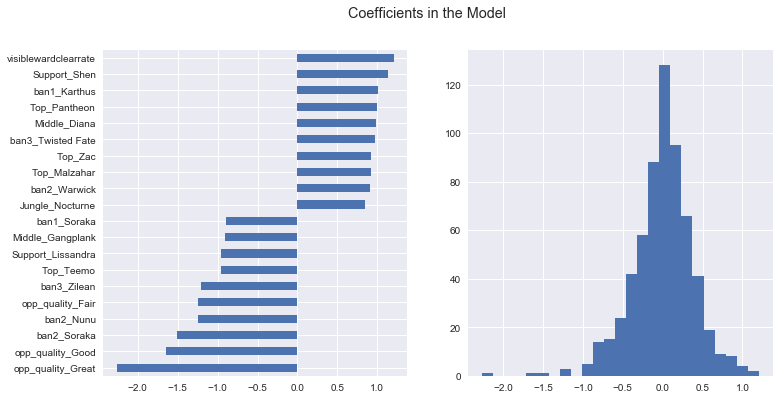

In [79]:
pg_X_train, pg_X_test, pg_y_train, pg_y_test = train_test_split(pg_X, pg_y, test_size = .25, random_state=10)
test.fit(pg_X_train, pg_y_train)
coef = pd.Series(test.coef_[0], index = pg_X_train.columns)
imp_coefs = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

plt.figure(figsize=(12, 6))
plt.subplot(121)
imp_coefs.plot(kind = "barh")
plt.suptitle("Coefficients in the Model")

plt.subplot(122)
coef.hist(bins = 25)

plt.show()

There's a lot of noise in this. While it is useful to see that ward clearing and opponent quality are important predictors, many of the dummy variables are likely receiving higher values than they rightly deserve due to limited observations (ie, support Shen was probably only played in a few games and it happened to win one or two of them). Another argument for clustering the champion selections.

Also, Top_Teemo should probably be closer to -$\infty$, so something is amiss.

In [96]:
playerDF.columns[playerDF.dtypes == 'category']

Index(['league', 'split', 'week', 'game', 'patchno', 'playerid', 'side',
       'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3',
       'ban4', 'ban5'],
      dtype='object')

In [134]:
k_players = playerDF.copy()
k_players.set_index(['gameid', 'player'], inplace = True)
k_players.sort_index(inplace = True)
k_players.drop(['url','league','split','date','week','game','playerid','ban1','ban2','ban3','ban4','ban5'],
               axis = 'columns', inplace = True)

In [135]:
print('Columns with all NaN values --', k_players.columns[k_players.isnull().all()].tolist())
k_players.dropna(axis = 'columns', how = 'all', inplace = True)
print('Columns with all NaN values --', k_players.columns[k_players.isnull().all()].tolist())

null_cols = k_players._get_numeric_data().columns[k_players._get_numeric_data().isnull().any()].tolist()
mean = k_players[null_cols].mean()
sd = k_players[null_cols].std()

Columns with all NaN values -- ['heraldtime', 'visiblewardclearrate', 'invisiblewardclearrate']
Columns with all NaN values -- []


In [136]:
outliers = {c:{'mean':mean[c], 'sd':sd[c],
               'values':[v for v in k_players[c] if abs(v - mean[c]) > 3*sd[c]]} for c in null_cols}
        
median_cols = [o for o in outliers.keys() if len(outliers[o]['values']) >= 100]
mean_cols = list(set(null_cols) - set(median_cols))

k_players[mean_cols] = k_players[mean_cols].fillna(k_players.mean())
k_players[median_cols] = k_players[median_cols].fillna(k_players.median())

if not k_players.isnull().values.any():
    print("NaN's successfully imputed")
else:
    print("NaN's remain in: ", k_players.columns[k_players.isnull().any()].tolist())

NaN's successfully imputed


In [161]:
tops = k_players.loc[k_players.position == 'Top', :].drop(['result','position'], axis = 'columns')
tops = pd.get_dummies(tops, columns = ['patchno','side','champion'])

jungs = k_players.loc[k_players.position == 'Jungle', :].drop(['result','position'], axis = 'columns')
jungs = pd.get_dummies(jungs, columns = ['patchno','side','champion'])

mids = k_players.loc[k_players.position == 'Middle', :].drop(['result','position'], axis = 'columns')
mids = pd.get_dummies(mids, columns = ['patchno','side','champion'])

adcs = k_players.loc[k_players.position == 'ADC', :].drop(['result','position'], axis = 'columns')
adcs = pd.get_dummies(adcs, columns = ['patchno','side','champion'])

sups = k_players.loc[k_players.position == 'Support', :].drop(['result','position'], axis = 'columns')
sups = pd.get_dummies(sups, columns = ['patchno','side','champion'])

In [162]:
for df in [tops, jungs, mids, adcs, sups]:
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df.drop(['team'], axis = 'columns'))
    df['cluster'] = kmeans.labels_

In [163]:
tops[['cluster','dmgshare', 'dmgtochampsperminute','k','d','a','teamkills',
           'gdat15','xpat10','wardshare']].groupby(['cluster']).mean()

,dmgshare,dmgtochampsperminute,k,d,a,teamkills,gdat15,xpat10,wardshare
cluster,,,,,,,,,
0,0.220613,454.711949,2.788799,2.577597,6.318940,14.005130,125.008551,4213.691770,0.145688
1,0.202078,365.494541,2.179148,2.432975,5.315267,12.163219,11.981796,3923.054772,0.164447
2,0.253501,590.418689,3.738983,2.913559,7.088983,16.049153,255.233898,4248.872881,0.147100
3,0.287398,753.704941,4.640678,3.630508,7.874576,17.816949,242.111864,4271.983051,0.145100
4,0.175950,261.558783,0.993440,2.582006,3.056232,7.424086,-338.760075,3883.280699,0.143180


In [164]:
for df in [tops, jungs, mids, adcs, sups]:
    try:
        df['cluster'] = df['cluster'].astype('category')
    except:
        print('Column {} cannot be converted to categorical.'.format(col))

In [182]:
top_clust = tops[['team','cluster']].copy()
top_clust.reset_index(inplace = True)
top_clust.set_index(['gameid','team'], inplace = True)
top_clust.sort_index(inplace = True)
top_clust.drop(['player'], axis = 'columns', inplace = True)
top_clust = pd.get_dummies(top_clust, prefix = 'TopLane_')
norm_teamDF = norm_teamDF.join(top_clust)

In [183]:
jung_clust = jungs[['team','cluster']].copy()
jung_clust.reset_index(inplace = True)
jung_clust.set_index(['gameid','team'], inplace = True)
jung_clust.sort_index(inplace = True)
jung_clust.drop(['player'], axis = 'columns', inplace = True)
jung_clust = pd.get_dummies(jung_clust, prefix = 'Jung_')
norm_teamDF = norm_teamDF.join(jung_clust)

In [184]:
mid_clust = mids[['team','cluster']].copy()
mid_clust.reset_index(inplace = True)
mid_clust.set_index(['gameid','team'], inplace = True)
mid_clust.sort_index(inplace = True)
mid_clust.drop(['player'], axis = 'columns', inplace = True)
mid_clust = pd.get_dummies(mid_clust, prefix = 'Mid_')
norm_teamDF = norm_teamDF.join(mid_clust)

In [185]:
adc_clust = adcs[['team','cluster']].copy()
adc_clust.reset_index(inplace = True)
adc_clust.set_index(['gameid','team'], inplace = True)
adc_clust.sort_index(inplace = True)
adc_clust.drop(['player'], axis = 'columns', inplace = True)
adc_clust = pd.get_dummies(adc_clust, prefix = 'AD_Carry_')
norm_teamDF = norm_teamDF.join(adc_clust)

In [187]:
sup_clust = sups[['team','cluster']].copy()
sup_clust.reset_index(inplace = True)
sup_clust.set_index(['gameid','team'], inplace = True)
sup_clust.sort_index(inplace = True)
sup_clust.drop(['player'], axis = 'columns', inplace = True)
sup_clust = pd.get_dummies(sup_clust, prefix = 'Sup_')
norm_teamDF = norm_teamDF.join(sup_clust)

In [192]:
old_dummies = [c for c in list(norm_teamDF) if any(d in c for d in ['ban', 'Jungle_', 'Middle_', 'Support_', 'Top_', 'ADC_'])]

clust_regs = list(set(list(norm_teamDF)) - set(vif_reducers) - set(in_game_feats) - set(old_dummies))

print('Kept features:', clust_regs)

Kept features: ['side_Red', 'TopLane__2', 'winRate', 'pace_Amble', 'AD_Carry__0', 'totalGames', 'pace_Walk', 'Sup__3', 'Mid__1', 'Sup__0', 'opp_quality_Fair', 'AD_Carry__1', 'Sup__2', 'AD_Carry__2', 'opp_quality_Good', 'AD_Carry__3', 'wpm', 'Mid__3', 'Jung__2', 'TopLane__4', 'Mid__0', 'invisiblewardclearrate', 'Sup__4', 'AD_Carry__4', 'aggression_Alert', 'pace_Trot', 'pace_Sprint', 'Jung__4', 'aggression_Moderate', 'visiblewardclearrate', 'TopLane__0', 'Jung__3', 'aggression_Wild', 'wcpm', 'quality_Fair', 'Sup__1', 'visionwards', 'TopLane__1', 'aggression_Frisky', 'quality_Good', 'quality_Great', 'quality_Poor', 'Mid__2', 'opp_quality_Great', 'opp_quality_Poor', 'Mid__4', 'Jung__1', 'visionwardbuys', 'fbarontime', 'Jung__0', 'TopLane__3']


In [193]:
cl_X = norm_teamDF.loc[:, clust_regs]
cl_y = norm_teamDF.loc[:,'result']

cl_lr = LogisticRegression()

cl_scores = cross_val_score(cl_lr, cl_X, cl_y, cv=10)
print("The clustered CV accuracies are:", cl_scores)
print("\nWith a mean accuracy of {}, a minimum of {}, and a maximum of {}".format(cl_scores.mean(),
                                                                                  min(cl_scores), max(cl_scores)))

pg_scores = cross_val_score(pg_lr, pg_X, pg_y, cv=10)
print("\nThe original pre-game CV accuracies were:", pg_scores)
print("\nWith a mean accuracy of {}, a minimum of {}, and a maximum of {}".format(pg_scores.mean(),
                                                                                  min(pg_scores), max(pg_scores)))

The clustered CV accuracies are: [ 0.78751165  0.78844362  0.78191985  0.78731343  0.81436567  0.7266791
  0.55835668  0.75443511  0.78898226  0.83473389]

With a mean accuracy of 0.7622741261958966, a minimum of 0.5583566760037348, and a maximum of 0.834733893557423

The original pre-game CV accuracies were: [ 0.72320596  0.71854613  0.70177074  0.71828358  0.74533582  0.67070896
  0.61344538  0.7254902   0.7254902   0.76097106]

With a mean accuracy of 0.7103248016783786, a minimum of 0.6134453781512605, and a maximum of 0.7609710550887021


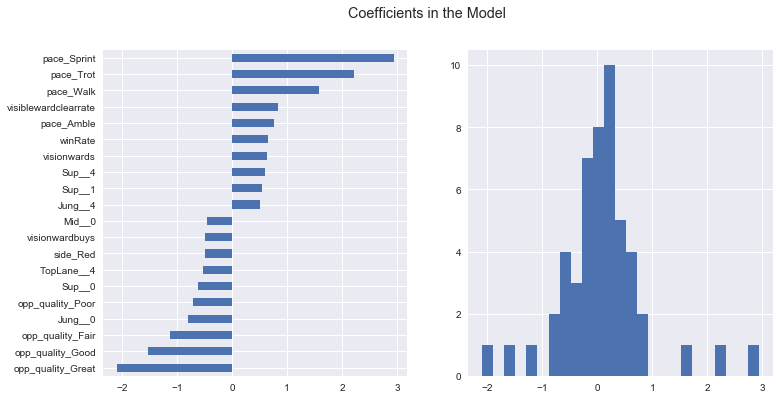

In [194]:
cl_X_train, cl_X_test, cl_y_train, cl_y_test = train_test_split(cl_X, cl_y, test_size = .25, random_state=10)
cl_lr = LogisticRegression()

cl_lr.fit(cl_X_train, cl_y_train)
coef = pd.Series(cl_lr.coef_[0], index = cl_X_train.columns)
imp_coefs = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

plt.figure(figsize=(12, 6))
plt.subplot(121)
imp_coefs.plot(kind = "barh")
plt.suptitle("Coefficients in the Model")

plt.subplot(122)
coef.hist(bins = 25)

plt.show()

NOTES:

- Can write a pickle file to save df's.
- Look to provide more context/explanation for the meaning of each cluster.
- Visualization technique TSNE (will lose on interpretability). Will project multidimensional space to 2D for cluster visualization.